In [2]:
import numpy as np
import pandas as pd
import math
import missingno as msno
from datetime import datetime as dt
import seaborn as sns
import re
import matplotlib.pyplot as plt
import json

In [3]:
df = pd.read_csv('us events ad_revenue filtered 03.02-07.02.csv')

In [4]:
df.sample(5)

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
61357,JLrm5o8XvHD,12,Samsung,SM-G991U,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 06:29:00,1644031740,2022-02-05 06:29:55,1644031795,wifi,U.S. Cellular,US,Cedar Falls
168578,JLsO3J4CVrE,11,Samsung,Galaxy S10+,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 04:11:17,1644109877,2022-02-06 04:11:26,1644109886,wifi,U.S. Cellular,US,Madison
156543,JLmYdB9k15m,12,Samsung,Galaxy S10e,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 22:08:41,1644001721,2022-02-04 22:09:28,1644001768,wifi,Verizon,US,NaN
227153,JLwGgpz7vg1,11,Samsung,Galaxy A20,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 03:18:38,1644106718,2022-02-06 03:18:40,1644106720,wifi,CC Network,US,NaN
281694,JLsFPYg9fA0,12,Samsung,Galaxy S21 Ultra 5G,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 04:45:32,1644025532,2022-02-05 04:45:34,1644025534,wifi,Verizon,US,NaN


<AxesSubplot:>

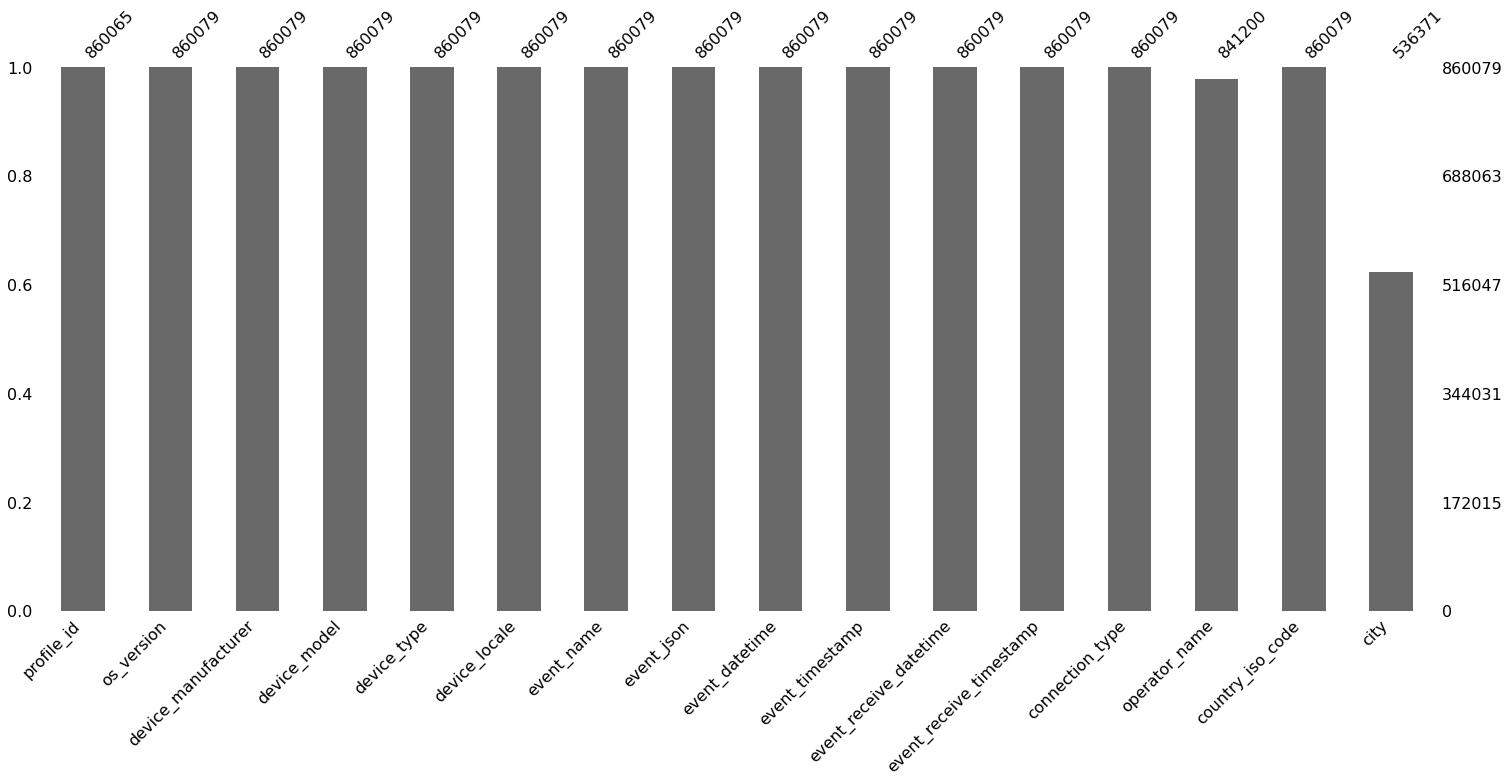

In [5]:
%matplotlib inline
msno.bar(df)

Из графика выше мы видим, что столбцы с именем оператора и с названием города юзера содержат пропуски.

<AxesSubplot:>

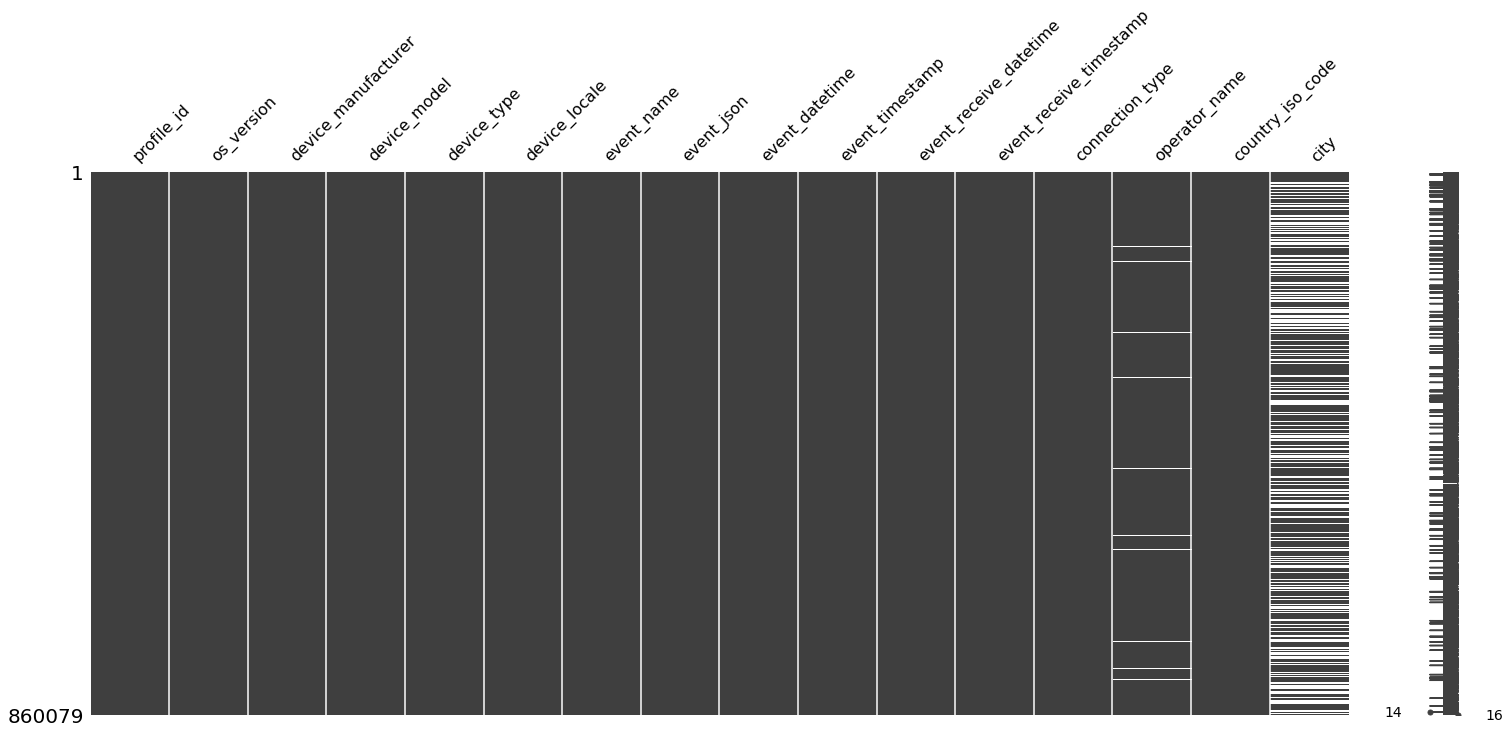

In [6]:
%matplotlib inline
msno.matrix(df)

С помощью этого графика, мы можем увидеть, что пропуски имеют случайный порядок и распределены достаточно равномерно. Данные пропуки скорее всего имеют естественное происхождение (например пользователь не ввел город проживания). 
## Приведение данных к верным типам.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860079 entries, 0 to 860078
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   profile_id               860065 non-null  object
 1   os_version               860079 non-null  object
 2   device_manufacturer      860079 non-null  object
 3   device_model             860079 non-null  object
 4   device_type              860079 non-null  object
 5   device_locale            860079 non-null  object
 6   event_name               860079 non-null  object
 7   event_json               860079 non-null  object
 8   event_datetime           860079 non-null  object
 9   event_timestamp          860079 non-null  int64 
 10  event_receive_datetime   860079 non-null  object
 11  event_receive_timestamp  860079 non-null  int64 
 12  connection_type          860079 non-null  object
 13  operator_name            841200 non-null  object
 14  country_iso_code    

In [8]:
df.event_datetime = pd.to_datetime(df.event_datetime, errors = 'coerce')
df.event_receive_datetime = pd.to_datetime(df.event_receive_datetime, errors = 'coerce')

In [9]:
df.event_json[0]

'{"ad_type":"banner","placement":"","view_index":1,"session_view_index":0,"cur_ticks":637795729492245130,"session_length":705.8807,"revenue":0.000510313,"ads_ltv":0.487876676518837,"ecpm_sma":0.511508107185364,"normalized_ecpm_sma":0.511508107185364,"value":0.000510313,"currency":"USD","ad_country_code":"US","network_name":"Google AdMob","ad_unit_id":"64c6b1114ea8c1cc","ad_network_placement":"ca-app-pub-7511632782617496/8825263691","creativeId":"CJ3XirfD5vUCFYPnKAUdG3MOYQ"}'

In [10]:
lst_ecpm_sma = []
lst_type = []

for i in df.event_json:
    ecpm_sma = json.loads(i)['ecpm_sma']
    ad_type = json.loads(i)['ad_type']
    lst_ecpm_sma.append(ecpm_sma)
    lst_type.append(ad_type)

In [11]:
df['ecpm_sma'] = lst_ecpm_sma
df['ad_type'] = lst_type

In [12]:
df.groupby('ad_type')['profile_id'].count()

ad_type
banner    815973
int        37610
rv          6482
Name: profile_id, dtype: int64

### Работа с выбросами

Для начала, необходимо ознакомится с распределением по переменной "ecpm_sma". Так как анализ проводится независимо от типа  рекламы, предлагаю оценивать распределения отдельно по каждому типу, ведь значение "ecpm_sma" может отличаться в других типах, а также по причине несбалансированности в этих трех классах.

<Figure size 216x1080 with 0 Axes>

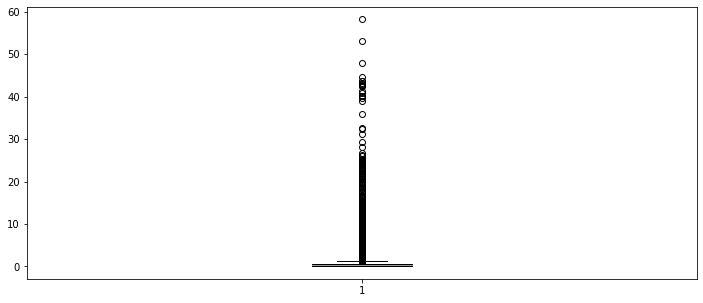

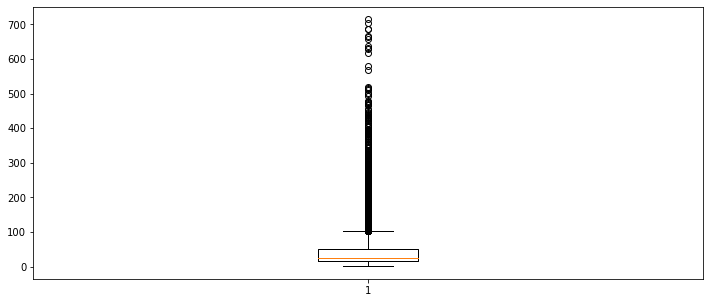

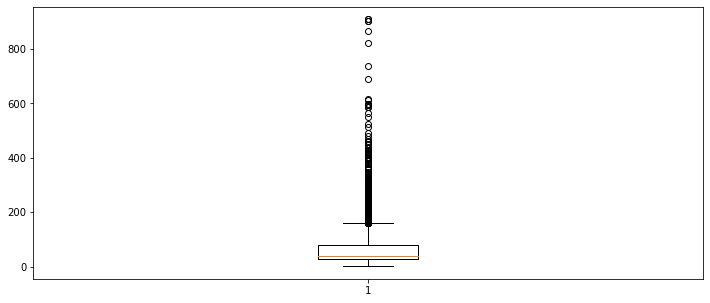

In [13]:
%matplotlib inline

fig = plt.figure(figsize = (3,15)) 
                            
for typ, data in df.groupby('ad_type'):
          
    fig, axes = plt.subplots(figsize = (12,5))
     
    plt.boxplot(data['ecpm_sma'])
    plt.show()

<Figure size 216x1080 with 0 Axes>

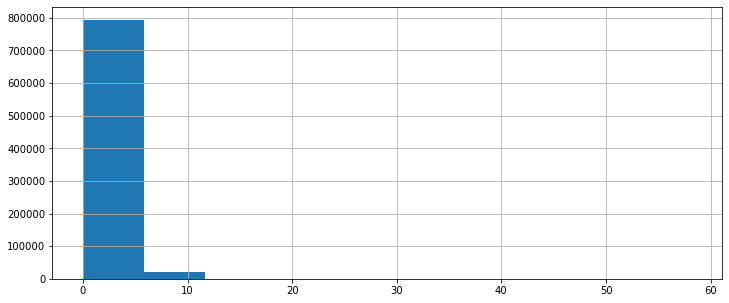

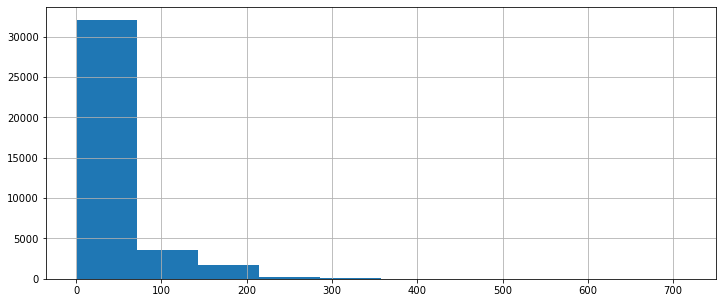

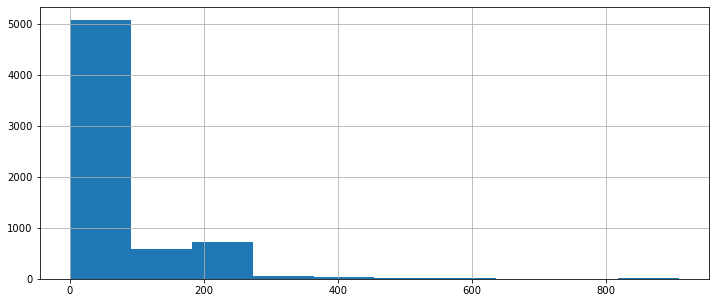

In [14]:
%matplotlib inline

fig = plt.figure(figsize = (3,15))                            
for typ, data in df.groupby('ad_type'):
          
    fig, axes = plt.subplots(figsize = (12,5))
     
    data.ecpm_sma.hist()
    plt.show()

Как мы вилим, в значении ecpm_sma много выбросов, выбросы показаны точками на ящичковой диаграмме, а видим, что среднее и медианное значения далеки друг от друга, также мы увидели, что распределение отличается для разных видов реклам. Для фильтрации выбросов воспользуемся правилом трех сигм.

In [15]:
def std_rules(df, column_name):
    a,b = df[column_name].mean() - 3 * df[column_name].std(), df[column_name].mean() + 3 * df[column_name].std()
    df = df[(df[column_name] > a)&(df[column_name] < b)]
    return(df)

<Figure size 216x1080 with 0 Axes>

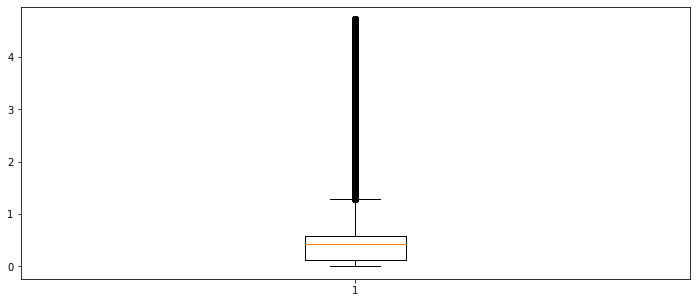

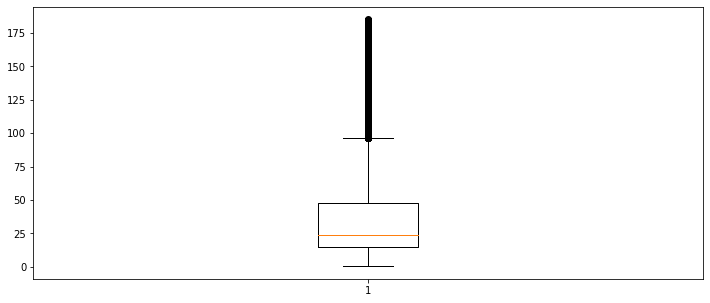

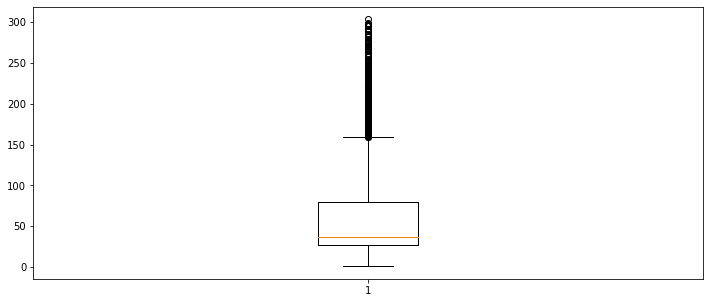

In [16]:
%matplotlib inline

fig = plt.figure(figsize = (3,15)) 
                            
for typ, data in df.groupby('ad_type'):
          
    fig, axes = plt.subplots(figsize = (12,5))
    
    plt.boxplot(std_rules(data,'ecpm_sma').ecpm_sma)
    plt.show()

<Figure size 216x1080 with 0 Axes>

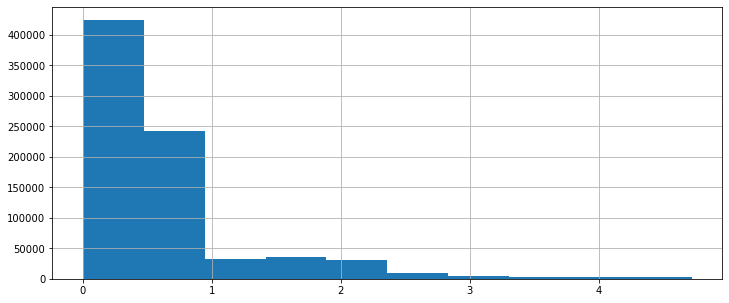

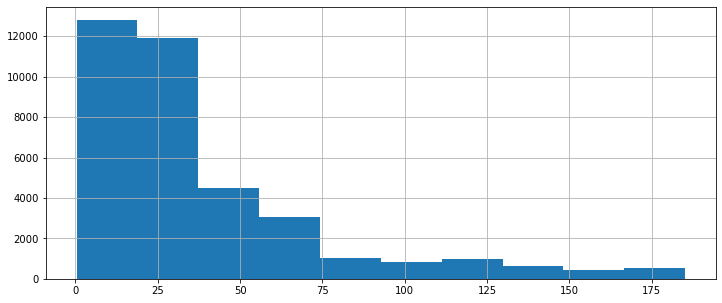

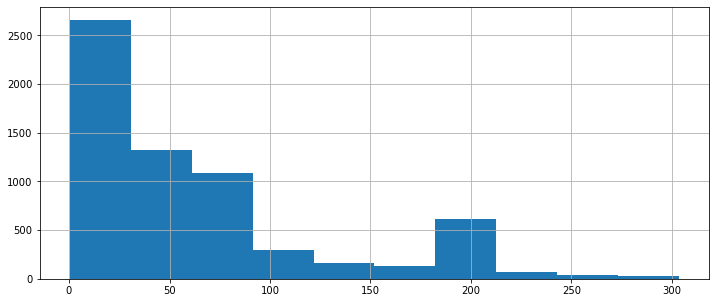

In [17]:
%matplotlib inline

fig = plt.figure(figsize = (3,15)) 
                            
for typ, data in df.groupby('ad_type'):
          
    fig, axes = plt.subplots(figsize = (12,5))
    
    std_rules(data,'ecpm_sma').ecpm_sma.hist()
    plt.show()

In [18]:
std_rules(df,'ecpm_sma').ecpm_sma.describe()

count    847999.000000
mean          1.602232
std           4.854184
min           0.001014
25%           0.136331
50%           0.472285
75%           0.720745
max          51.067402
Name: ecpm_sma, dtype: float64

Среднее и медианное значение стали ближе, но картина распределения не сильно изменилось, ато связано с тем, что в данных достаточно большое стандартное отклонение. Еще один способ избавиться от выбросов в данных удаление квантилей "сверху" и "снизу".

In [19]:
def drop_quantile(df, column_name, n):
    a,b = df[column_name].quantile(q= n/100), df[column_name].quantile(q=(100-n)/100)
    df = df[(df[column_name] > a)&(df[column_name] < b)]
    return(df)

<Figure size 216x1080 with 0 Axes>

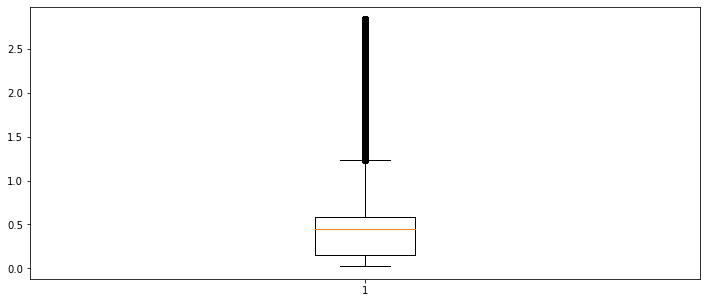

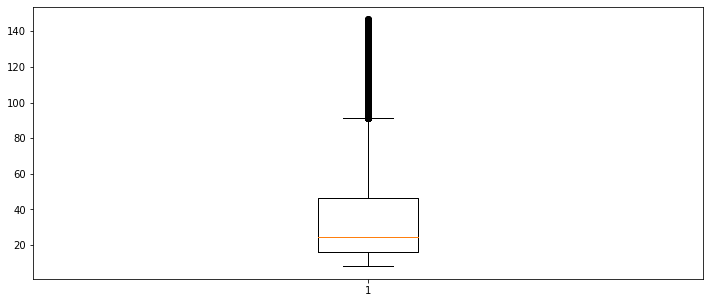

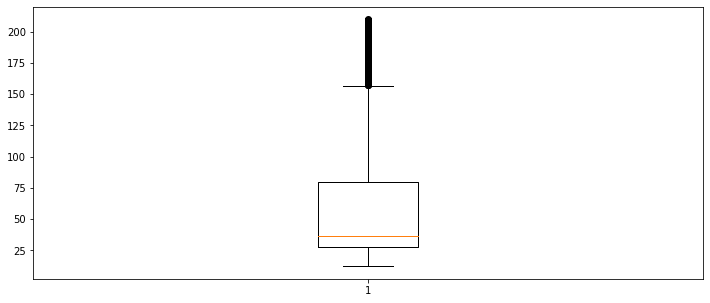

In [20]:
%matplotlib inline

fig = plt.figure(figsize = (3,15)) 
                            
for typ, data in df.groupby('ad_type'):
          
    fig, axes = plt.subplots(figsize = (12,5))
    
    plt.boxplot(drop_quantile(data,'ecpm_sma', 5).ecpm_sma)
    plt.show()

<Figure size 216x1080 with 0 Axes>

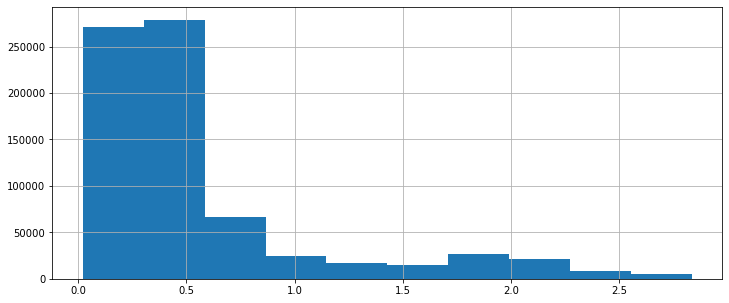

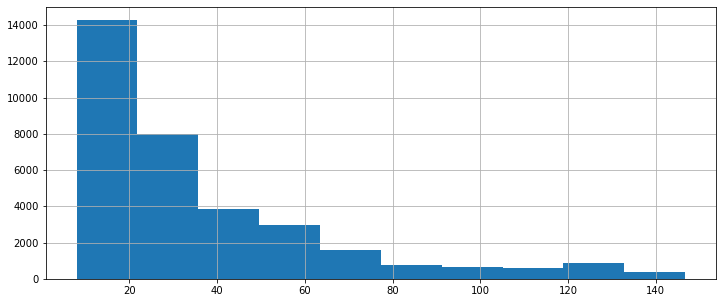

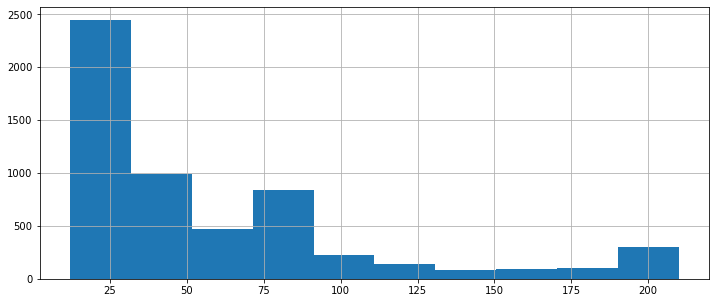

In [21]:
%matplotlib inline

fig = plt.figure(figsize = (3,15)) 
                            
for typ, data in df.groupby('ad_type'):
          
    fig, axes = plt.subplots(figsize = (12,5))
    
    drop_quantile(data,'ecpm_sma', 5).ecpm_sma.hist()
    plt.show()

С помощью этого метода мы  получили более благоприятную статистическую картину. Но выбросов остается достаточно много, чтобы считать задачу выполненной. Данные методы не лучший выбор для имеющихся данных, так как все выбросы имеют специфичное расположение (много выше серединных значений). Воспользуемся медианным фильтром.

In [25]:
def median_filter(df, column_name):
    difference = np.abs(df[column_name].median()-df[column_name])
    median_abs_deviation = df[column_name].median()
    threshold = 3 * median_abs_deviation
    outlier_idx = difference > threshold
    df = df[df[column_name] <= threshold]
    return(df)

<Figure size 216x1080 with 0 Axes>

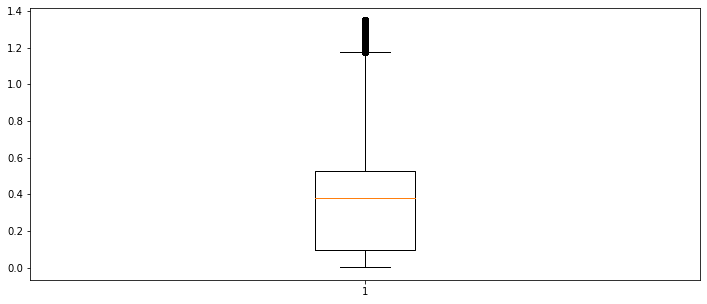

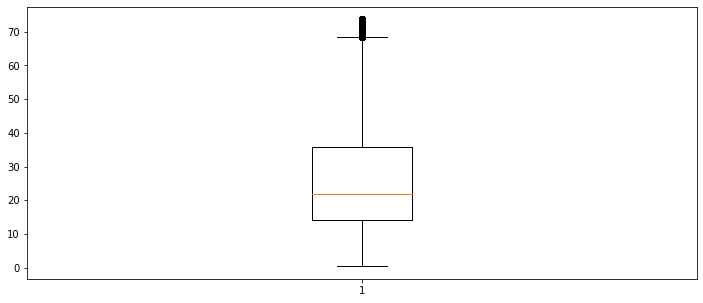

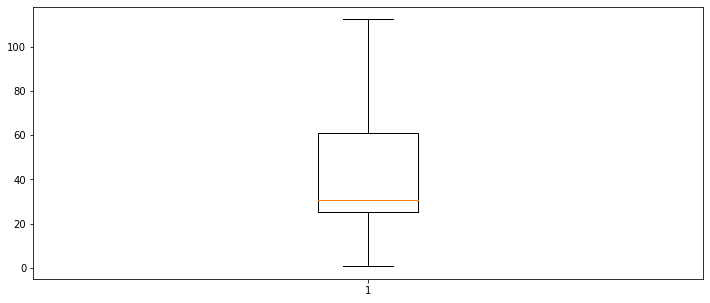

In [26]:
%matplotlib inline

fig = plt.figure(figsize = (3,15)) 
                            
for typ, data in df.groupby('ad_type'):
          
    fig, axes = plt.subplots(figsize = (12,5))
    
    plt.boxplot(median_filter(data,'ecpm_sma').ecpm_sma)
    plt.show()

<Figure size 216x1080 with 0 Axes>

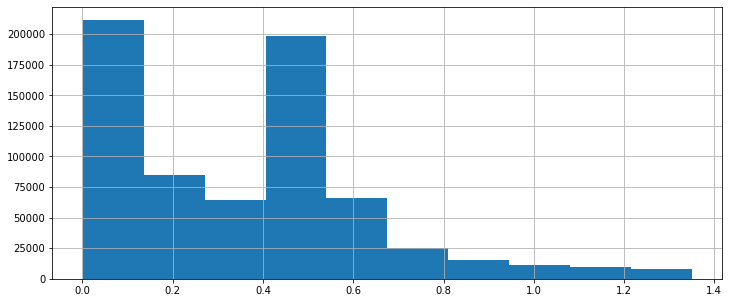

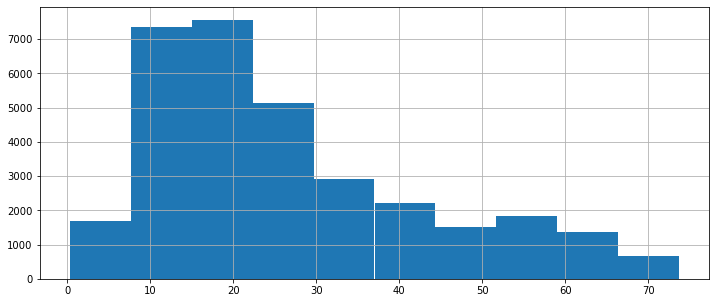

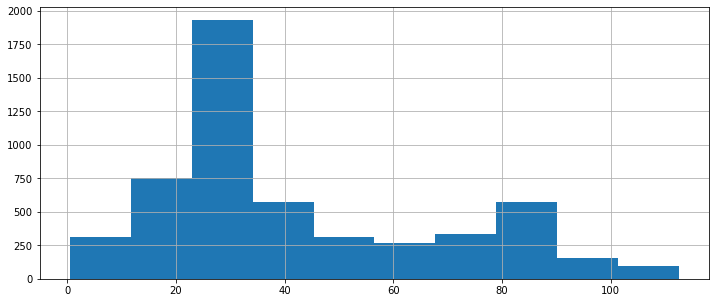

In [27]:
%matplotlib inline

fig = plt.figure(figsize = (3,15)) 
                            
for typ, data in df.groupby('ad_type'):
          
    fig, axes = plt.subplots(figsize = (12,5))
    
    median_filter(data,'ecpm_sma').ecpm_sma.hist()
    plt.show()

С помощью медианного фильтра мы получили наилучший результат.

In [28]:
df_1 = pd.DataFrame()

In [29]:
for typ, data in df.groupby('ad_type'):
    df_1 = pd.concat([df_1, median_filter(data,'ecpm_sma')], axis=0)

In [30]:
df.ecpm_sma.describe()

count    860079.000000
mean          3.147110
std          15.973978
min           0.001014
25%           0.139942
50%           0.480991
75%           0.772006
max         908.876160
Name: ecpm_sma, dtype: float64

In [31]:
df_1.ecpm_sma.describe()

count    732768.000000
mean          1.818542
std           7.581069
min           0.001014
25%           0.105258
50%           0.415637
75%           0.535226
max         112.496613
Name: ecpm_sma, dtype: float64

### Распределение средних eCPM-ов юзеров по типу рекламы

<Figure size 216x1080 with 0 Axes>

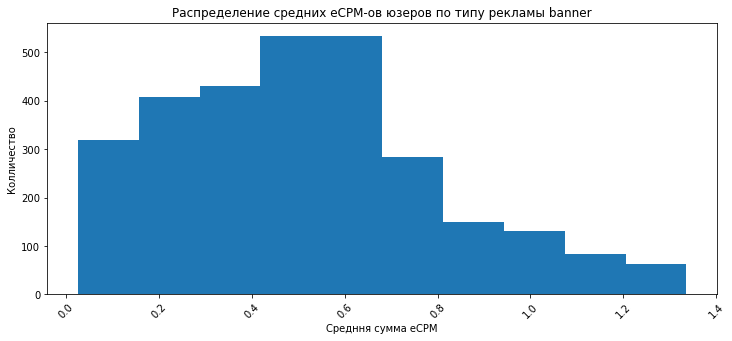

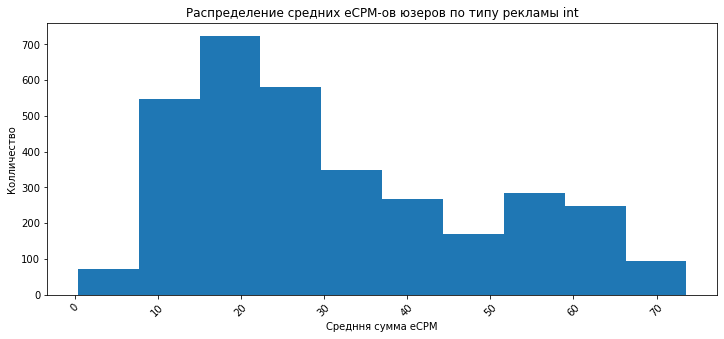

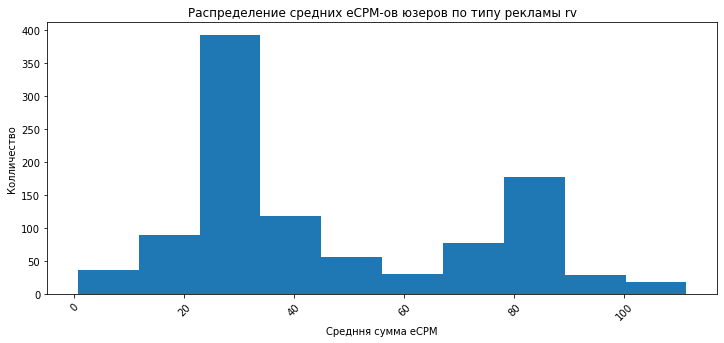

In [32]:
%matplotlib inline

fig = plt.figure(figsize = (3,15))                               
for typ, data in df_1.groupby('ad_type'):
    
        
    fig, axes = plt.subplots(figsize = (12,5))
     
    pd.DataFrame(data.groupby('profile_id')['ecpm_sma'].mean()).ecpm_sma.hist()
    
    plt.xlabel('Средння сумма eCPM')  
    plt.ylabel('Колличество')
    
    plt.grid()
    plt.xticks(rotation=45)
      
    plt.title('Распределение средних eCPM-ов юзеров по типу рекламы {}'.format(typ))
    
    plt.show()

### Распределение  eCPM-ов по городам и  типу рекламы

In [67]:
for typ, data in df_1.groupby('ad_type'):
    print('Распределение eCPM-ов по городам, тип рекламы {}'.format(typ))
    print(data.pivot_table(index = 'city', values= 'ecpm_sma',  
                 aggfunc=['sum','mean','median','count']).sort_values(by = ('count', 'ecpm_sma'), 
                                                                                           ascending=False).head(50))
    print('------------------------------------------------------------------------')

Распределение eCPM-ов по городам, тип рекламы banner
                       sum      mean    median    count
                  ecpm_sma  ecpm_sma  ecpm_sma ecpm_sma
city                                                   
New York       5649.526953  0.403826  0.448615    13990
Minneapolis    4055.235914  0.378111  0.372264    10725
Springfield    4020.646151  0.430016  0.510313     9350
Houston        2905.566015  0.379564  0.379297     7655
Chicago        2148.644053  0.284551  0.212913     7551
Charlotte      2981.317944  0.402500  0.432453     7407
San Antonio    1237.203932  0.173084  0.066217     7148
Gallatin       1451.822192  0.229646  0.181048     6322
Gig Harbor     1670.006145  0.285276  0.269839     5854
Kansas City    1616.192274  0.285647  0.175955     5658
Los Angeles    1633.086382  0.297683  0.219117     5486
Denver         2174.982020  0.402998  0.415372     5397
Tulsa          1311.851978  0.274274  0.172666     4783
Columbus       2108.559947  0.442975  0.497471     

### Распределение  eCPM-ов по OS и  типу рекламы

In [75]:
for typ, data in df_1.groupby('ad_type'):
    print('Распределение eCPM-ов по OS, тип рекламы {}'.format(typ))
    print(data.pivot_table(index = 'os_version', values= 'ecpm_sma',  
                 aggfunc=['sum','mean','median','count']).sort_values(by = ('count', 'ecpm_sma'), 
                                                                                           ascending=False)
    print('------------------------------------------------------------------------')

Распределение eCPM-ов по OS, тип рекламы banner
                      sum      mean    median    count
                 ecpm_sma  ecpm_sma  ecpm_sma ecpm_sma
os_version                                            
12          127630.389349  0.409860  0.444920   311400
11           52983.122619  0.307496  0.226653   172305
10           45231.111592  0.351695  0.353468   128609
9            19309.810814  0.327891  0.303187    58891
8.1.0         2490.551110  0.287029  0.219510     8677
8.0.0         2116.402103  0.289958  0.236567     7299
7.0            935.032149  0.250679  0.135533     3730
7.1.2          249.455676  0.143283  0.073233     1741
7.1.1          279.931570  0.223588  0.107820     1252
5.0.2          156.378828  0.228290  0.111123      685
6.0.1          151.030150  0.232712  0.164289      649
------------------------------------------------------------------------
Распределение eCPM-ов по OS, тип рекламы int
                      sum       mean     median    count
       

### Распределение  доходов по городам и  типу рекламы

In [72]:
lst_revenue = []

for i in df_1.event_json:
    revenue = json.loads(i)['revenue']
    lst_revenue.append(revenue)

In [73]:
df_1['revenue'] =lst_revenue

In [74]:
for typ, data in df_1.groupby('ad_type'):
    print('Распределение доходов по городам, тип рекламы {}'.format(typ))
    print(data.pivot_table(index = 'city', values= 'revenue',  
                 aggfunc=['sum','mean','median','count']).sort_values(by = ('count', 'revenue'), 
                                                                                           ascending=False).head(50))
    print('------------------------------------------------------------------------')

Распределение доходов по городам, тип рекламы banner
                    sum      mean    median   count
                revenue   revenue   revenue revenue
city                                               
New York       5.471628  0.000391  0.000438   13990
Minneapolis    3.827717  0.000357  0.000438   10725
Springfield    3.996486  0.000427  0.000510    9350
Houston        2.819429  0.000368  0.000438    7655
Chicago        2.068765  0.000274  0.000098    7551
Charlotte      2.843802  0.000384  0.000432    7407
San Antonio    1.150450  0.000161  0.000013    7148
Gallatin       1.449786  0.000229  0.000019    6322
Gig Harbor     1.664688  0.000284  0.000142    5854
Kansas City    1.557562  0.000275  0.000080    5658
Los Angeles    1.534512  0.000280  0.000105    5486
Denver         2.086150  0.000387  0.000438    5397
Tulsa          1.229494  0.000257  0.000074    4783
Columbus       2.025057  0.000425  0.000497    4760
Ventura        1.777634  0.000385  0.000514    4616
Dallas     

### Распределение доходов по OS и типу рекламы

In [76]:
for typ, data in df_1.groupby('ad_type'):
    print('Распределение доходов по OS, тип рекламы {}'.format(typ))
    print(data.pivot_table(index = 'os_version', values= 'revenue',  
                 aggfunc=['sum','mean','median','count']).sort_values(by = ('count', 'revenue'), 
                                                                                           ascending=False)
    print('------------------------------------------------------------------------')

Распределение доходов по OS, тип рекламы banner
                   sum      mean    median   count
               revenue   revenue   revenue revenue
os_version                                        
12          121.835787  0.000391  0.000438  311400
11           49.549149  0.000288  0.000095  172305
10           43.086048  0.000335  0.000438  128609
9            18.546633  0.000315  0.000432   58891
8.1.0         2.401638  0.000277  0.000079    8677
8.0.0         2.032004  0.000278  0.000081    7299
7.0           0.867770  0.000233  0.000058    3730
7.1.2         0.252216  0.000145  0.000012    1741
7.1.1         0.275766  0.000220  0.000041    1252
5.0.2         0.135827  0.000198  0.000065     685
6.0.1         0.145733  0.000225  0.000075     649
------------------------------------------------------------------------
Распределение доходов по OS, тип рекламы int
                   sum      mean    median   count
               revenue   revenue   revenue revenue
os_version        

### Оценка значимости и выводы
Для того, чтобы определить отличаются ли значения в данных таблицах по типу рекламы, необходимо воспользоваться критерием Мана-Уитни, который используется в случае независимых выборок ( как у нас здесь)

In [113]:
def make_data(df, type_, agg, grouper, how):
    df = df[df.ad_type == type_]
    df = df.pivot_table(index = grouper, values= how,  
                 aggfunc=[agg]).sort_values(by = (agg, how), ascending=False).head(50)
    df.columns = ['arg']
    return df

In [86]:
from scipy.stats import mannwhitneyu

In [88]:
def U_test(series_1, series_2):   
    stat, p = mannwhitneyu(series_1, series_2)
    print('Критерий значимости = %.3f' % (p))
    alpha = 0.05
    if p > alpha:
        print('Незначимые различия', np.round(series_1.mean(), 2),', ', np.round(series_2.mean(),2))
    else:
        print('Значимые различия ', np.round(series_1.mean(), 2),', ', np.round(series_2.mean(),2))

Теперь нам удобно сравнить средние значения в разных выборках, привидем пример иследования на значимость различия между средними значениями ecpm по типу рекламы:

In [115]:
U_test(make_data(df_1, 'int', 'mean', 'city', 'ecpm_sma').arg,
       make_data(df_1, 'banner', 'mean', 'city', 'ecpm_sma').arg)

Критерий значимости = 0.000
Значимые различия  64.85 ,  1.08


Также можно посмотреть как отличаются ecpm внутри одного города для разных типов реклам:

In [123]:
a = make_data(df_1, 'int', 'mean', 'city', 'ecpm_sma')
b = make_data(df_1, 'rv', 'mean', 'city', 'ecpm_sma')
t = a.merge(b, on='city')

In [124]:
t

,arg_x,arg_y
city,,
Littleton,69.055651,91.129433
Kingsport,65.948166,79.994881
Bellevue,65.920148,79.994881
Youngstown,64.558780,80.788048
Salem,60.733538,92.726374
Rocky Mount,59.245486,93.489395


Привожу упрощенную форму, так как данное иследование имеет тестовый характер

In [125]:
for i in t.index:
    print(i)
    U_test(t.arg_x,t.arg_y)

Littleton
Критерий значимости = 0.002
Значимые различия  64.24 ,  86.35
Kingsport
Критерий значимости = 0.002
Значимые различия  64.24 ,  86.35
Bellevue
Критерий значимости = 0.002
Значимые различия  64.24 ,  86.35
Youngstown
Критерий значимости = 0.002
Значимые различия  64.24 ,  86.35
Salem
Критерий значимости = 0.002
Значимые различия  64.24 ,  86.35
Rocky Mount
Критерий значимости = 0.002
Значимые различия  64.24 ,  86.35


Применяя различные статистические тесты, мы можем убедиться в достоверности своих иследований в случаях независимости выборок и их разной величины.
Как мы видим, что ecpm зависит от типа реккламы и действительно отличается для разных типов('int' и 'rv').


In [129]:
a = make_data(df_1, 'int', 'mean', 'city', 'revenue')
b = make_data(df_1, 'banner', 'mean', 'city', 'revenue')
t = a.merge(b, on='city')

In [130]:
t

,arg_x,arg_y
city,,
Modesto,0.105732,0.001075
Farmingville,0.082317,0.002056
Wylie,0.074922,0.000892
Idaho Falls,0.066480,0.000801
Sandy,0.065350,0.000839
Gulfport,0.065213,0.000787
Fresno,0.062366,0.001265
Clarkesville,0.059520,0.000831


In [131]:
for i in t.index:
    print(i)
    U_test(t.arg_x,t.arg_y)

Modesto
Критерий значимости = 0.000
Значимые различия  0.07 ,  0.0
Farmingville
Критерий значимости = 0.000
Значимые различия  0.07 ,  0.0
Wylie
Критерий значимости = 0.000
Значимые различия  0.07 ,  0.0
Idaho Falls
Критерий значимости = 0.000
Значимые различия  0.07 ,  0.0
Sandy
Критерий значимости = 0.000
Значимые различия  0.07 ,  0.0
Gulfport
Критерий значимости = 0.000
Значимые различия  0.07 ,  0.0
Fresno
Критерий значимости = 0.000
Значимые различия  0.07 ,  0.0
Clarkesville
Критерий значимости = 0.000
Значимые различия  0.07 ,  0.0


Пример того, что доход также зависит от типа реккламы и действительно отличается для разных типов('int' и 'banner').
По аналогии мы можем провести более полное иследование на текущих данных.
### Изучение зависимости eCPM от времени суток.


In [136]:
df_1['hour'] = df_1.event_receive_datetime.dt.hour

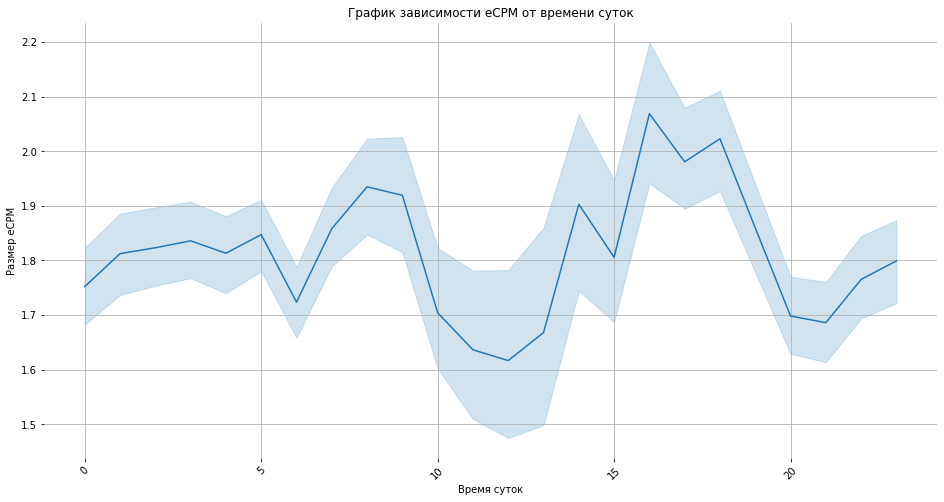

In [139]:
%matplotlib inline

fig,axes = plt.subplots(figsize = (16,8))
     
sns.lineplot(data = df_1, x= 'hour', y = 'ecpm_sma' )
sns.color_palette('bright')
    
plt.xlabel('Время суток')  
plt.ylabel('Размер eCPM')
    
plt.grid()
plt.xticks(rotation=45)
    

plt.title('График зависимости eCPM от времени суток')
plt.box(on=None)
plt.show()

In [145]:
#Слишком долгое выполнение кода
# %matplotlib inline

# fig,axes = plt.subplots(figsize = (16,8))
     
# sns.lineplot(data = df_1.sort_values(by = 'event_receive_datetime'), x= 'event_receive_datetime', y = 'ecpm_sma' )
# sns.color_palette('bright')
    
# plt.xlabel('Дата')  
# plt.ylabel('Размер eCPM')
    
# plt.grid()
# plt.xticks(rotation=45)
    

# plt.title('Временной ряд eCPM')
# plt.box(on=None)
# plt.show()

In [152]:
df_2 = df_1.sort_values(by = 'hour')

In [154]:
series = np.array(df_2.ecpm_sma)
split = int(len(series) / 2)
first = series[0:split]
second = series[split:]
mean_1, mean_2 = first.mean(), second.mean()
print('Средние в первой половине дня ',round(mean_1,2), ', cредние во второй половине дня ', round(mean_2, 2))

Средние в первой половине дня  1.8 , cредние во второй половине дня  1.84


Уже сейчас видно, что даже в случае  тест подтвердит значимость различий в течения дня- различия останутся несущественными, также на графике не наблюдается линейной зависимости, но можно выделить тренд более низкого eCPM в середине дня и более высокого - вечером.

### Проверка стационарности ряда методом Дики Фуллера

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
#Слишком долгое выполнение кода
# stat, p = adfuller(series)